### **Mount Google Drive:**



In [40]:
#reference : https://stackoverflow.com/questions/62117483/import-module-in-google-colab-from-google-drive-python
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **Imports:**


In [46]:
# import and display image
import numpy as np
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

#!pip install tensorflow==2.9

# Import TensorFlow
import tensorflow as tf
print(tf.__version__)
from tensorflow import keras
from keras import layers, models

# keras layers and regulairzers import
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Dense, Input
from tensorflow.keras.layers import Activation, Concatenate, Conv2D, Multiply
from tensorflow.keras.layers import Layer, Conv2D, GlobalAveragePooling2D, Dense, Multiply, Add, Reshape, Permute, Activation,Dropout,BatchNormalization
from tensorflow.keras.regularizers import l2

# keras callbacks
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# utils and pre-processing
from tensorflow.keras.utils import load_img, img_to_array
from tf.keras.applications.efficientnet import preprocess_input


2.9.0


### **Defining batch and image size:**

In [42]:
import tensorflow as tf
# Define the data directory and other parameters
data_dir = '/content/drive/MyDrive/STATE_FARM_DATASET/train'

batch_size = 64
image_size = (224, 224)

### **Data Augmentation using Image Generator:**

In [43]:
#reference: https://stackoverflow.com/questions/49019929/keras-imagedatagenerator-preprocessing
# Create an instance of the ImageDataGenerator
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=30,
        zoom_range=0.2,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        horizontal_flip=False,
        fill_mode="nearest",
        validation_split=0.20)

# Create a TensorFlow Dataset from the State Farm dataset directory
train_dataset = train_datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode="rgb",
    subset='training',
    shuffle=True,
    seed=42
)
val_dataset = train_datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode="rgb",
    subset='validation',
    shuffle=True,
    seed=42
)

Found 17943 images belonging to 10 classes.
Found 4481 images belonging to 10 classes.


### **Display Augmented Images:**

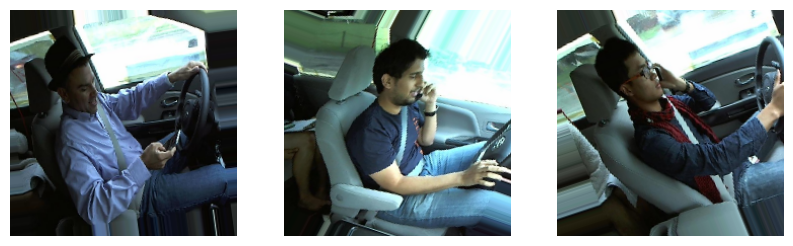

In [44]:
# reference:https://www.tensorflow.org/tutorials/images/classification
plt.figure(figsize=(10, 10))
for i in range(3):
    augmented_img, _ = next(train_dataset)
    plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_img[0].astype(np.uint8))
    plt.axis('off')
plt.show()

### **Convolutional Block Attention Mechanism:**


*   Implemented spatial and channel attention
*   Convolutional 2D layer of filter = 1
*   Kernel size - 3x3



In [ ]:
#reference: https://github.com/nikhilroxtomar/Attention-Mechanism-Implementation/blob/main/TensorFlow/cbam.py
def channel_attention_module(x, ratio=8):
    batch, _, _, channel = x.shape

    ## Shared layers
    l1 = Dense(channel//ratio, activation="relu", use_bias=False)
    l2 = Dense(channel, use_bias=False)

    ## Global Average Pooling 2D
    x1 = GlobalAveragePooling2D()(x)
    x1 = l1(x1)
    x1 = l2(x1)

    ## Global Max Pooling 2D
    x2 = GlobalMaxPooling2D()(x)
    x2 = l1(x2)
    x2 = l2(x2)

    ## Add both the features and pass through sigmoid
    feats = x1 + x2
    feats = Activation("sigmoid")(feats)
    feats = Multiply()([x, feats])

    return feats

def spatial_attention_module(x):
    ## Average Pooling
    x1 = tf.reduce_mean(x, axis=-1)
    x1 = tf.expand_dims(x1, axis=-1)

    ## Max Pooling
    x2 = tf.reduce_max(x, axis=-1)
    x2 = tf.expand_dims(x2, axis=-1)

    ## Concatenat both the features
    feats = Concatenate()([x1, x2])
    ## Conv 2D layer, filter size = 1
    feats = Conv2D(1, kernel_size=(5,5), padding="same", activation="sigmoid")(feats)
    feats = Multiply()([x, feats])

    return feats

def cbam(x):
    x = channel_attention_module(x)
    x = spatial_attention_module(x)
    return x

### **Load pre-trained EfficientNetB3 model. Fine tuning the model with hyperparameter settings.**



*   Input = (224,224,3)
*   GlobalAveragePooling2D
*   Dense Layers 512-256
*   Dropout value - 0.2/0.25



In [ ]:
# Load the pre-trained EfficientNetV3 model
#reference: https://www.tensorflow.org/api_docs/python/tf/keras/applications/efficientnet/EfficientNetB3
base_model = tf.keras.applications.efficientnet.EfficientNetB3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False
# Create a new input tensor for the model
inputs = tf.keras.Input(shape=(224, 224, 3))

# Output of the EfficientNetB3 model
efficientNetB3_output = base_model(inputs)

# Apply CBAM on top of EfficientNetB3 output
cbam_output = cbam(efficientNetB3_output)

# Create classification head
x = GlobalAveragePooling2D()(cbam_output)
x = BatchNormalization()(x)

x = Dense(512,activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(256,activation='relu')(x)
x = Dropout(0.25)(x)

outputs = Dense(10, activation='softmax')(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

# Print model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 efficientnetb3 (Functional)    (None, 7, 7, 1536)   10783535    ['input_2[0][0]']                
                                                                                                  
 global_average_pooling2d (Glob  (None, 1536)        0           ['efficientnetb3[0][0]']         
 alAveragePooling2D)                                                                              
                                                                                              

### **Model Compilation:**


*   Adam Optimiser - learning rate = 0.001

*   Loss - Categorical crossentropy
*   Metrics - Accuracy


*   Early Stopping - Patience = 5



In [ ]:
#reference: https://keras.io/api/callbacks/model_checkpoint/
# Compile the model
model.compile(tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy',metrics=['accuracy'])
checkpointer = ModelCheckpoint('/content/drive/MyDrive/best_models/EfficientNetB3_cbam512_256_64lr0.001_batch64_k5_wdrop_withglobbatchnorm.hdf5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
es = EarlyStopping(monitor='val_loss',patience=5, min_delta = 0.001, verbose = 1,  restore_best_weights=True)

### **Model Training:**

*   Epochs = 25


In [ ]:
# Training the model
model.fit(train_dataset,
    steps_per_epoch=train_dataset.samples // train_dataset.batch_size,
    epochs=50,
    validation_data=val_dataset,
    validation_steps=val_dataset.samples // val_dataset.batch_size,callbacks=[es,checkpointer])

Epoch 1/50
280/280 [==============================] - ETA: 0s - loss: 0.9930 - accuracy: 0.6570
Epoch 1: val_loss improved from inf to 0.61015, saving model to /content/drive/MyDrive/best_models/EfficientNetB3_cbam512_256_64lr0.001_batch64_k5_wdrop_withglobbatchnorm.hdf5
280/280 [==============================] - 595s 2s/step - loss: 0.9930 - accuracy: 0.6570 - val_loss: 0.6102 - val_accuracy: 0.8259
Epoch 2/50
280/280 [==============================] - ETA: 0s - loss: 0.5558 - accuracy: 0.8137
Epoch 2: val_loss improved from 0.61015 to 0.35156, saving model to /content/drive/MyDrive/best_models/EfficientNetB3_cbam512_256_64lr0.001_batch64_k5_wdrop_withglobbatchnorm.hdf5
280/280 [==============================] - 574s 2s/step - loss: 0.5558 - accuracy: 0.8137 - val_loss: 0.3516 - val_accuracy: 0.8884
Epoch 3/50
280/280 [==============================] - ETA: 0s - loss: 0.4241 - accuracy: 0.8578
Epoch 3: val_loss improved from 0.35156 to 0.23689, saving model to /content/drive/MyDrive/b

### **Save the best model:**

In [7]:
# Load the best model from the saved checkpoint
#reference:https://keras.io/api/callbacks/model_checkpoint/
best_model = tf.keras.models.load_model('/content/drive/MyDrive/best_models/EfficientNetB3_with_cbam512_256_lr1e3_batch128finalv1.0.hdf5')

### **Model Training and Validation Loss:**

In [ ]:
fig = plt.figure(figsize = (15,8))
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training loss','validation loss'], loc='upper right')
plt.show()

### **Model Training and Validation Accuracy:**

In [ ]:
fig = plt.figure(figsize = (15,8))
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training accuracy','validation accuracy'], loc='upper right')
plt.show()

### **Evaluate the model:**

In [45]:
val_loss, val_accuracy = best_model.evaluate(val_dataset,steps=val_dataset.samples // val_dataset.batch_size,verbose=1)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

70/70 [==============================] - 1062s 15s/step - loss: 0.0793 - accuracy: 0.9746
Validation Loss: 0.07925768941640854
Validation Accuracy: 0.9745535850524902


### **Load test samples:**

In [ ]:
test_dir1 = "/content/drive/MyDrive/STATE_FARM_DATASET/TEST_FOLDER/manual_testdataset02/state_farm_dataset1"
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=None)
test_generator = test_datagen.flow_from_directory(
    test_dir1,
    target_size=image_size,
    batch_size=8,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False
)

### **Confusion Matrix - Test Data**

28/28 [==============================] - 6s 143ms/step


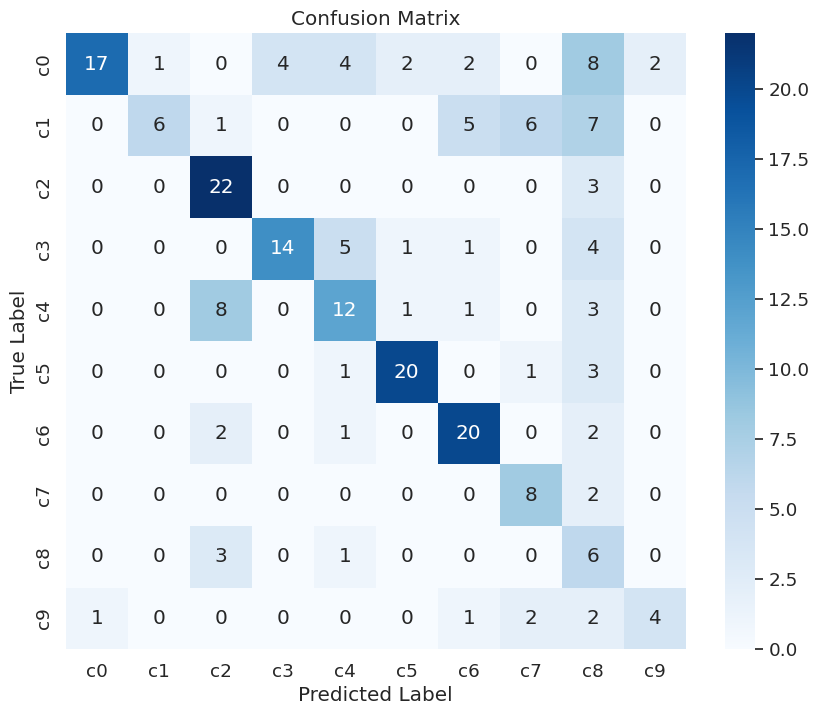

In [18]:
true_labels = test_generator.classes

num_classes = len(test_generator.class_indices)
predictions = best_model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)

# Create the confusion matrix
conf_matrix_test = confusion_matrix(true_labels, predicted_labels)

#reference: https://stackoverflow.com/questions/61526287/how-to-add-correct-labels-for-seaborn-confusion-matrix
# Plot the confusion matrix heatmap with counts inside
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap="Blues", xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### **Test Accuracy per Class:**

In [19]:
#reference:https://stackoverflow.com/questions/39770376/scikit-learn-get-accuracy-scores-for-each-class
def calculate_per_class_accuracy_test(conf_matrix):
    num_classes = conf_matrix.shape[0]
    accuracy_dict = {}

    for i in range(num_classes):
        true_positive = conf_matrix[i, i]
        total_predictions = sum(conf_matrix[i, :])
        accuracy = true_positive / total_predictions

        accuracy_dict[i] = accuracy

    return accuracy_dict

per_class_accuracy = calculate_per_class_accuracy_test(conf_matrix_test)
class_names = ["c0", "c1", "c2","c3","c4","c5","c6","c7","c8","c9"]  # Replace with your class names

for i, class_name in enumerate(class_names):
    print(f"Accuracy for {class_name}: {per_class_accuracy[i]:.4f}")

mean_accuracy = sum(per_class_accuracy.values()) / len(per_class_accuracy)
print(f"Overall Mean Accuracy: {mean_accuracy:.4f}")


Accuracy for c0: 0.4250
Accuracy for c1: 0.2400
Accuracy for c2: 0.8800
Accuracy for c3: 0.5600
Accuracy for c4: 0.4800
Accuracy for c5: 0.8000
Accuracy for c6: 0.8000
Accuracy for c7: 0.8000
Accuracy for c8: 0.6000
Accuracy for c9: 0.4000
Overall Mean Accuracy: 0.5985


### **Get Class Labels:**

In [19]:
def get_labels(predicted_label_index):

  if predicted_label_index == 0:
    return "Safe driving"
  elif predicted_label_index == 1:
    return "Text right"
  elif predicted_label_index == 2:
    return "Talk right"
  elif predicted_label_index == 3:
    return "Text left"
  elif predicted_label_index == 4:
    return "Talk left"
  elif predicted_label_index == 5:
    return "Audio System"
  elif predicted_label_index == 6:
    return "Drink"
  elif predicted_label_index == 8:
    return "Reach Behind"
  elif predicted_label_index == 8:
    return "Hair and Makeup"
  else:
    return "Talk to passenger"




### **Check Predictions:**


*   Correctly predicted labels


1/1 [==============================] - 0s 84ms/step


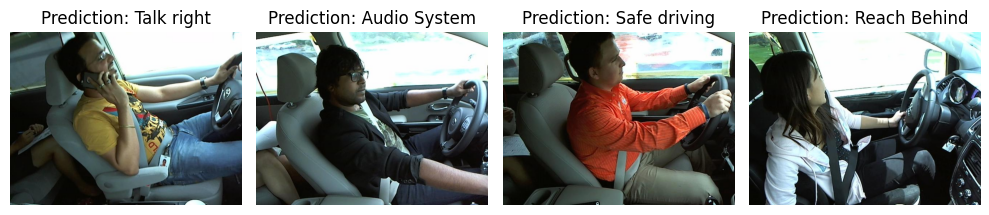

In [29]:
image_paths = [
    '/content/drive/MyDrive/STATE_FARM_DATASET/TEST_FOLDER/manual_testdataset02/state_farm_dataset1/c2/img_49.jpg',
    '/content/drive/MyDrive/STATE_FARM_DATASET/TEST_FOLDER/manual_testdataset02/state_farm_dataset1/c5/img_238.jpg',
    '/content/drive/MyDrive/STATE_FARM_DATASET/TEST_FOLDER/manual_testdataset02/state_farm_dataset1/c0/img_404.jpg',
    '/content/drive/MyDrive/STATE_FARM_DATASET/TEST_FOLDER/manual_testdataset02/state_farm_dataset1/c7/img_176.jpg'
]

# Create a figure with multiple subplots arranged horizontally
num_images = len(image_paths)
fig, axes = plt.subplots(1, num_images, figsize=(10, 10))

# Loop through image paths
for i, img_path in enumerate(image_paths):
    # Load and preprocess the image
    my_image = load_img(img_path, target_size=(224, 224))
    my_image = img_to_array(my_image)
    my_image = np.expand_dims(my_image, axis=0)
    my_image = preprocess_input(my_image)

    # Make the prediction
    prediction_single = best_model.predict(my_image)
    predicted_label_index = np.argmax(prediction_single)

    predicted_label = get_labels(predicted_label_index)

    # Load the image using plt.imread
    img = plt.imread(img_path)

    # Plot the image on a subplot
    axes[i].imshow(img)
    axes[i].set_title(f'Prediction: {predicted_label}',size = 12)
    axes[i].axis('off')

# Adjust layout spacing between subplots
plt.tight_layout()
plt.show()


### **Check Predictions:**


*   False positives



1/1 [==============================] - 0s 82ms/step


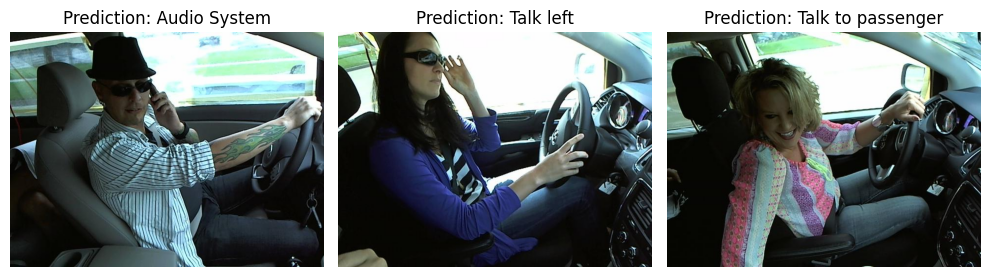

In [39]:
image_paths = [
    '/content/drive/MyDrive/STATE_FARM_DATASET/TEST_FOLDER/manual_testdataset02/state_farm_dataset1/c4/img_519.jpg',
    '/content/drive/MyDrive/STATE_FARM_DATASET/TEST_FOLDER/manual_testdataset02/state_farm_dataset1/c8/img_386.jpg',
    '/content/drive/MyDrive/STATE_FARM_DATASET/TEST_FOLDER/manual_testdataset02/state_farm_dataset1/c7/img_171.jpg'
]

# Create a figure with multiple subplots arranged horizontally
num_images = len(image_paths)
fig, axes = plt.subplots(1, num_images, figsize=(10, 10))

# Loop through image paths
for i, img_path in enumerate(image_paths):
    # Load and preprocess the image
    my_image = load_img(img_path, target_size=(224, 224))
    my_image = img_to_array(my_image)
    my_image = np.expand_dims(my_image, axis=0)
    my_image = preprocess_input(my_image)

    # Make the prediction
    prediction_single = best_model.predict(my_image)
    predicted_label_index = np.argmax(prediction_single)

    predicted_label = get_labels(predicted_label_index)

    # Load the image using plt.imread
    img = plt.imread(img_path)

    # Plot the image on a subplot
    axes[i].imshow(img)
    axes[i].set_title(f'Prediction: {predicted_label}',size = 12)
    axes[i].axis('off')

# Adjust layout spacing between subplots
plt.tight_layout()
plt.show()
